In [43]:
# Packages
import pandas as pd 
import os
import geopandas as gpd
import matplotlib.pyplot as plt

LOAD THE DATA

In [44]:
# LOAD THE DATA
os.chdir("C:/Users/Soledad.Acuna/Desktop/tesis")

banks = pd.read_excel("banks_location.xlsx")
business = pd.read_excel("business.xlsx")
sociodemographic = pd.read_excel("sociodemographic.xlsx")
census_map = gpd.read_file("secciones_censales_sociodemo_2014.shp")
spain_map = gpd.read_file("recintos_autonomicas_inspire_peninbal_etrs89.shp")

CLEAN THE DATA

In [51]:
# a) census_map
# Create the column CUSEC from "sscc" (dropping the first number) 
census_map['CUSEC'] = census_map['sscc'].str[1:]
census_map['CUSEC'] = census_map['CUSEC'].astype(str)

# b) spain_map
# Keep only necessary columns
spain_map = spain_map[['CODNUT2', 'geometry']]
# Filter: ES51 (Cataluña) y ES30 (Madrid)
spain_map = spain_map[spain_map['CODNUT2'].isin(['ES51', 'ES30'])]
spain_map['provincia'] = spain_map['CODNUT2'].map({
    'ES51': 'Cataluña',
    'ES30': 'Madrid'
})

# c) business
business['CUSEC'] = business['CUSEC'].astype(str)


# d) banks
# Definir provincias que pertenecen a Cataluña
provincias_cat = ['BARCELONA', 'GIRONA', 'LLEIDA', 'TARRAGONA']
# Crear nueva columna 'provincia' con condiciones
banks['provincia'] = banks['PROVINCE'].apply(
    lambda x: 'Cataluña' if x in provincias_cat else ('Madrid' if x == 'MADRID' else None)
)
banks['CUSEC'] = banks['CUSEC'].astype(str)

# Crear columna "entidad" agrupada
def normalizar_entidad(e):
    e = str(e).strip().upper()
    if e == 'CAIXABANK':
        return 'CaixaBank'
    elif e in ['SANTANDER', 'BANCO SANTANDER']:
        return 'Santander'
    elif e == 'BBVA':
        return 'BBVA'
    elif e in ['BANCO DE SABADELL', 'SABADELL']:
        return 'Sabadell'
    elif e == 'BANKINTER':
        return 'Bankinter'
    else:
        return 'Otros'
# Aplicar la función a la columna original
banks['entidad'] = banks['ENTITY'].apply(normalizar_entidad)

In [ ]:
business

BANKS 

In [46]:
# Agrupación limpia
tabla = banks.groupby(['entidad', 'provincia']).size().unstack(fill_value=0)
# Renombrar columnas
tabla.columns.name = None  # Elimina nombre del índice de columnas
tabla = tabla.rename(columns={
    'Cataluña': 'Branches_Cataluña',
    'Madrid': 'Branches_Madrid'
})
# Resetear el índice y asegurarse de que solo existan columnas deseadas
tabla = tabla.reset_index()
# Calcular total
tabla['Total'] = tabla['Branches_Cataluña'] + tabla['Branches_Madrid']
# Reordenar columnas y eliminar cualquier sobrante inesperado
tabla = tabla[['entidad', 'Branches_Cataluña', 'Branches_Madrid', 'Total']]
# Ordenar y mostrar
tabla = tabla.sort_values(by='Total', ascending=False)
print(tabla)


     entidad  Branches_Cataluña  Branches_Madrid  Total
2  CaixaBank                751              440   1191
3      Otros                456              110    566
5  Santander                219              330    549
4   Sabadell                325               97    422
0       BBVA                  0              224    224
1  Bankinter                 40               90    130


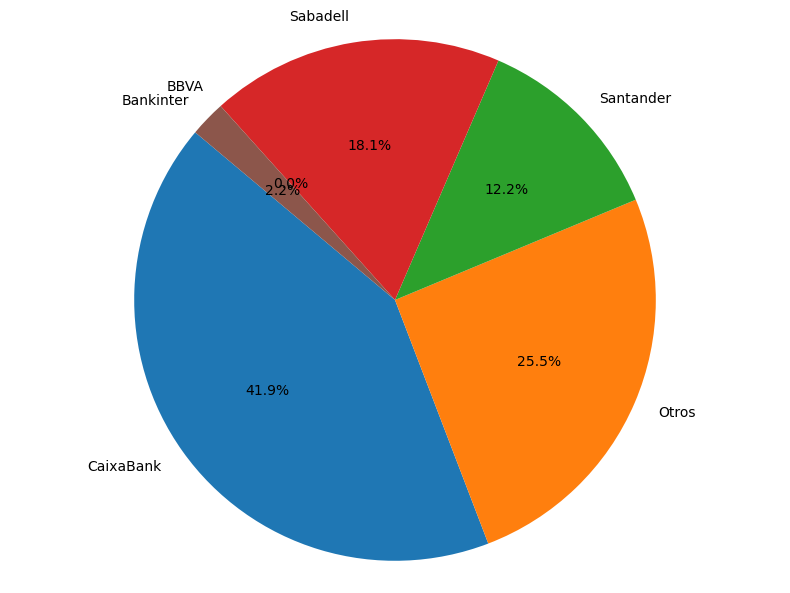

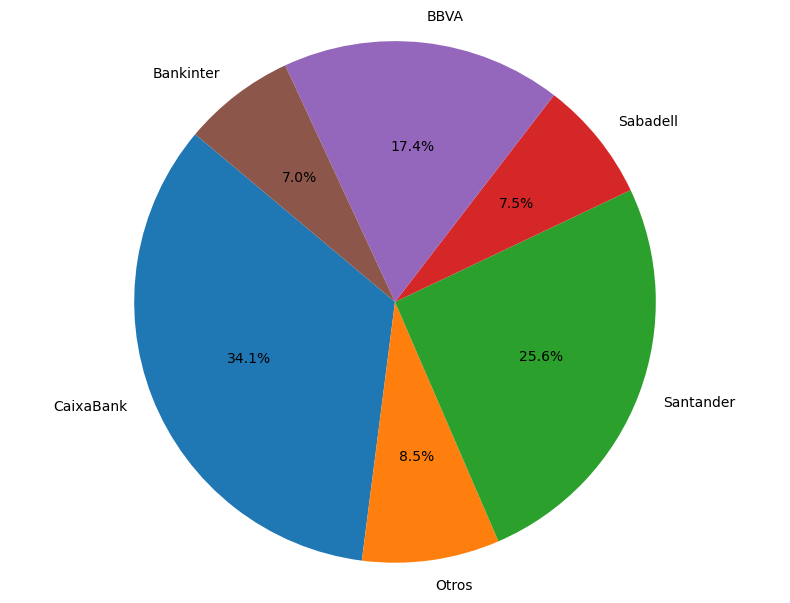

In [47]:
# Gráfico para Cataluña
plt.figure(figsize=(8, 6))
plt.pie(
    tabla['Branches_Cataluña'],
    labels=tabla['entidad'],
    autopct='%1.1f%%',
    startangle=140
)
plt.axis('equal')  # Para que el círculo sea redondo
plt.tight_layout()
plt.show()

# Gráfico para Madrid
plt.figure(figsize=(8, 6))
plt.pie(
    tabla['Branches_Madrid'],
    labels=tabla['entidad'],
    autopct='%1.1f%%',
    startangle=140
)
plt.axis('equal')
plt.tight_layout()
plt.show()


C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_17888\3120595839.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  catalunya_shape = spain_map[spain_map['provincia'] == 'Cataluña'].unary_union
C:\Users\Soledad.Acuna\AppData\Local\Temp\ipykernel_17888\3120595839.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  madrid_shape = spain_map[spain_map['provincia'] == 'Madrid'].unary_union


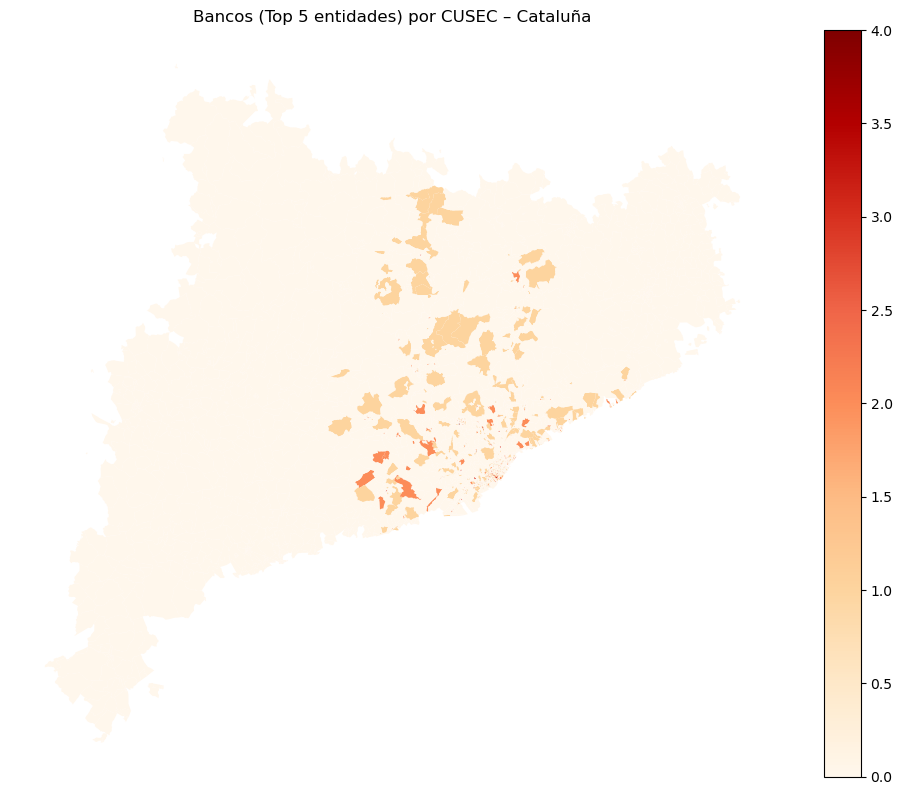

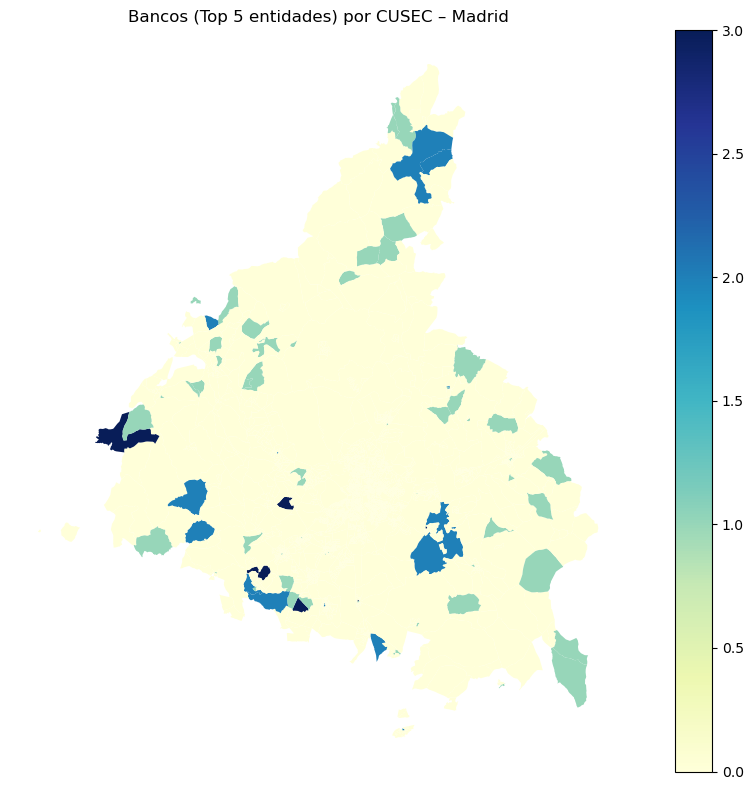

In [50]:
# Filtrar solo entidades deseadas
bancos_top5 = ['CaixaBank', 'BBVA', 'Sabadell', 'Bankinter', 'Santander']
banks_filtrado = banks[banks['entidad'].isin(bancos_top5)]

# Contar número de bancos por CUSEC (solo esas entidades)
bank_counts = banks_filtrado['CUSEC'].value_counts().reset_index()
bank_counts.columns = ['CUSEC', 'num_bancos']

# Unir con el mapa
census_map = census_map.merge(bank_counts, on='CUSEC', how='left')
census_map['num_bancos'] = census_map['num_bancos'].fillna(0)

# Filtrar por Cataluña y Madrid usando spain_map
catalunya_shape = spain_map[spain_map['provincia'] == 'Cataluña'].unary_union
madrid_shape = spain_map[spain_map['provincia'] == 'Madrid'].unary_union

mapa_cat = census_map[census_map.geometry.within(catalunya_shape)]
mapa_mad = census_map[census_map.geometry.within(madrid_shape)]

# Mapa de Cataluña
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_cat.plot(column='num_bancos', cmap='OrRd', legend=True, ax=ax)
ax.set_title("Bancos (Top 5 entidades) por CUSEC – Cataluña")
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_mad.plot(column='num_bancos', cmap='YlGnBu', legend=True, ax=ax)
ax.set_title("Bancos (Top 5 entidades) por CUSEC – Madrid")
ax.axis('off')
plt.tight_layout()
plt.show()


BUSINESS

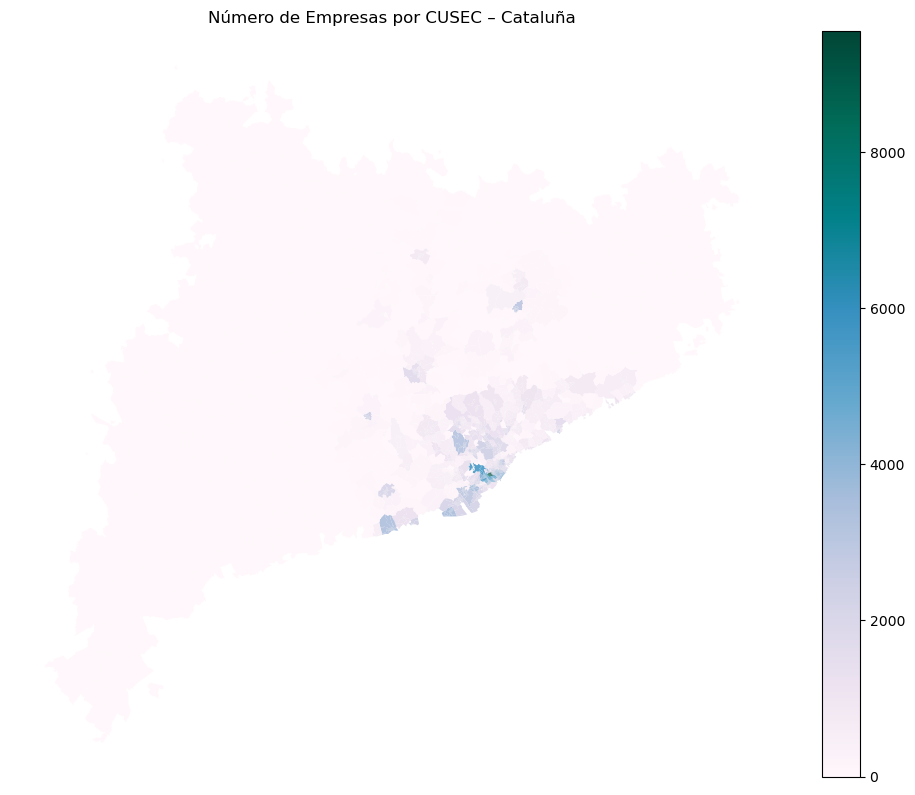

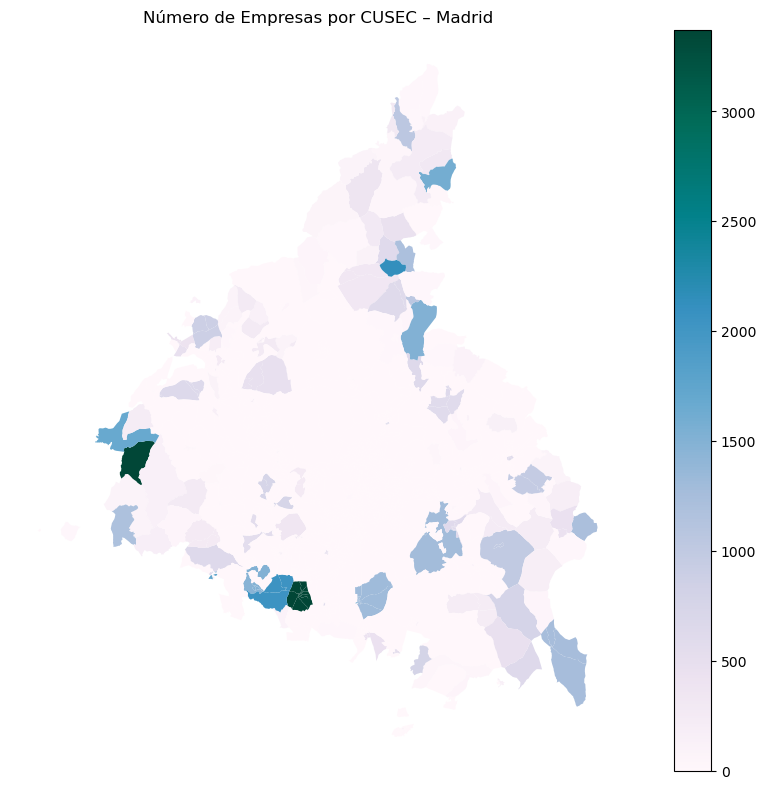

In [53]:
# Unir NumCompanies al mapa censal
census_map_empresas = census_map.merge(business[['CUSEC', 'total_NumCompanies']], on='CUSEC', how='left')
census_map_empresas['total_NumCompanies'] = census_map_empresas['total_NumCompanies'].fillna(0)

mapa_cat_empresas = census_map_empresas[census_map_empresas.geometry.within(catalunya_shape)]
mapa_mad_empresas = census_map_empresas[census_map_empresas.geometry.within(madrid_shape)]

# Mapa de Cataluña - Empresas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_cat_empresas.plot(column='total_NumCompanies', cmap='PuBuGn', legend=True, ax=ax)
ax.set_title("Número de Empresas por CUSEC – Cataluña")
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid - Empresas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_mad_empresas.plot(column='total_NumCompanies', cmap='PuBuGn', legend=True, ax=ax)
ax.set_title("Número de Empresas por CUSEC – Madrid")
ax.axis('off')
plt.tight_layout()
plt.show()


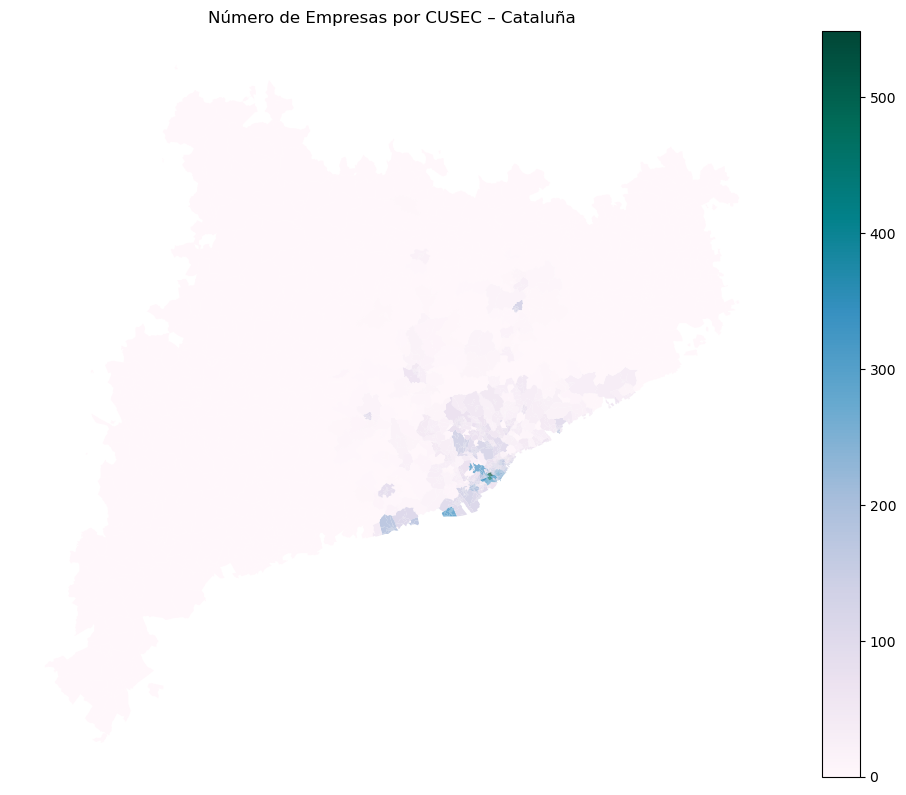

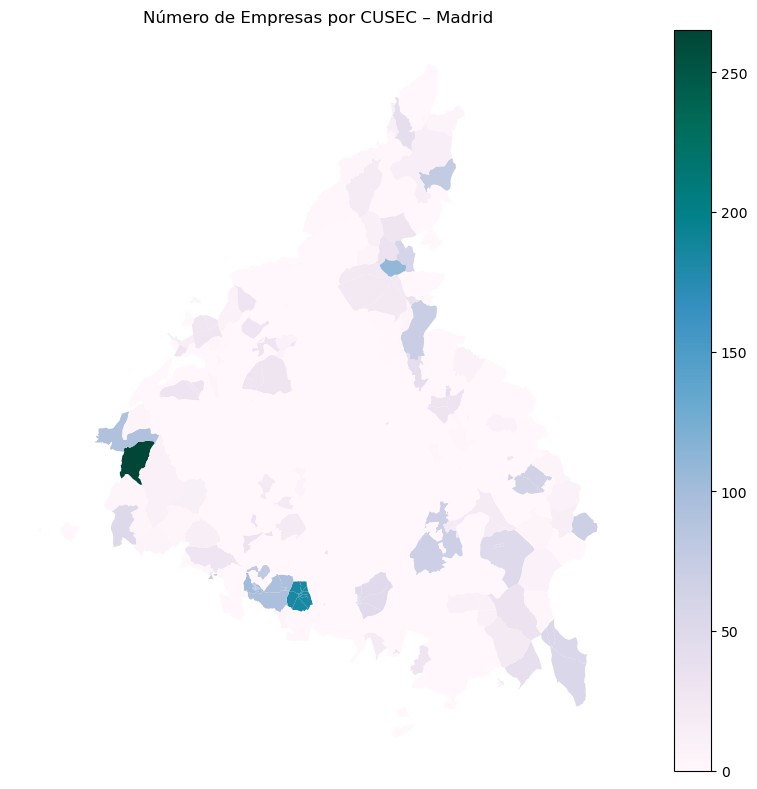

In [54]:
# Unir NumCompanies al mapa censal
census_map_empresas = census_map.merge(business[['CUSEC', 'total_NumCompaniesNewCreation']], on='CUSEC', how='left')
census_map_empresas['total_NumCompaniesNewCreation'] = census_map_empresas['total_NumCompaniesNewCreation'].fillna(0)

mapa_cat_empresas = census_map_empresas[census_map_empresas.geometry.within(catalunya_shape)]
mapa_mad_empresas = census_map_empresas[census_map_empresas.geometry.within(madrid_shape)]

# Mapa de Cataluña - Empresas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_cat_empresas.plot(column='total_NumCompaniesNewCreation', cmap='PuBuGn', legend=True, ax=ax)
ax.set_title("Número de Empresas por CUSEC – Cataluña")
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid - Empresas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mapa_mad_empresas.plot(column='total_NumCompaniesNewCreation', cmap='PuBuGn', legend=True, ax=ax)
ax.set_title("Número de Empresas por CUSEC – Madrid")
ax.axis('off')
plt.tight_layout()
plt.show()
